In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import os
import re
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
diagnostics={"NORM":['NORM','CSD'],
             "STTC":['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ],
             "MI":['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL'],
             "HYP":['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP'],
             "CD":['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB', '2AVB'],
             "OTHER":['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC']
            }

In [4]:
diagnostics['MI']

['IMI',
 'ASMI',
 'ILMI',
 'AMI',
 'ALMI',
 'INJAS',
 'LMI',
 'INJAL',
 'IPLMI',
 'IPMI',
 'INJIN',
 'INJLA',
 'PMI',
 'INJIL']

In [5]:
ecg_data=pd.read_csv('/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [6]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837 entries, 0 to 21836
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21837 non-null  int64  
 1   patient_id                    21837 non-null  float64
 2   age                           21748 non-null  float64
 3   sex                           21837 non-null  int64  
 4   height                        6983 non-null   float64
 5   weight                        9429 non-null   float64
 6   nurse                         20328 non-null  float64
 7   site                          21819 non-null  float64
 8   device                        21837 non-null  object 
 9   recording_date                21837 non-null  object 
 10  report                        21837 non-null  object 
 11  scp_codes                     21837 non-null  object 
 12  heart_axis                    13332 non-null  object 
 13  i

In [40]:
#Merging the diagnosis into a superclass:
labels=[]
discard=[]
for index in range(ecg_data.shape[0]):
    counter=0
    temp_diag=ecg_data['scp_codes'][index]
    temp_diag=re.sub('{',"",str(temp_diag))
    temp_diag=re.sub('}',"",temp_diag)
    temp_diag=temp_diag.split(',')                 
    len_diag=len(temp_diag)
    for idx in range(len_diag):
        temp_d=temp_diag[idx]
        temp_d=temp_d.split(':')[0]
        temp_d=re.sub(r'[^\w\s]',"",temp_d)
        if temp_d in diagnostics['NORM']:
            label=0
            counter=1
        elif temp_d in diagnostics['STTC']:
            label=1
            counter=1
        elif temp_d in diagnostics['MI']:
            label=2
            counter=1
        elif temp_d in diagnostics['HYP']:
            label=3
            counter=1
        elif temp_d in diagnostics['CD']:
            label=4
            counter=1
        elif temp_d in diagnostics['OTHER']:
            label=5
            counter=1
        else:
            label=100
        labels.append(label)
    if counter==0:
        discard.append(index)

In [41]:
final_labels=[]
for index in range(len(labels)):
    if labels[index]!=100:
        final_labels.append(labels[index])

In [42]:
final_data=ecg_data.drop(axis=0,index=discard)

In [43]:
final_data['Labels']=final_labels

In [44]:
final_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,Labels
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,0


<Axes: xlabel='Labels', ylabel='count'>

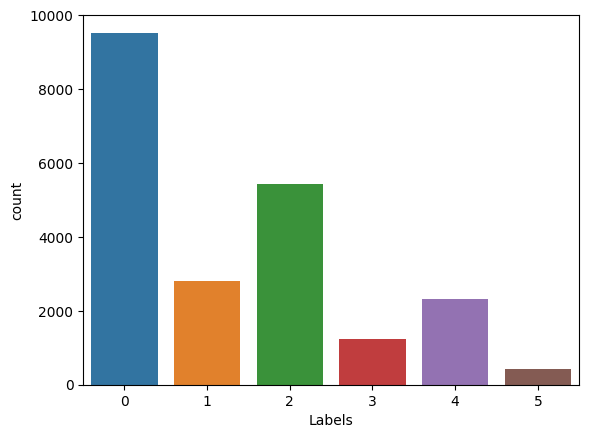

In [45]:
sns.countplot(data=final_data,x='Labels')

In [46]:
class ECG_Data(Dataset):
    def __init__(self,dataframe):
        self.data=dataframe
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        path='/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'+self.data['filename_lr'][idx]
        file_audio=wfdb.rdsamp(path)
        data=file_audio
        data_new=np.array(data[0])
        data_new=np.transpose(data_new,(1,0))
        #data_final=data_new[7]
        data_final = data_new
        label=self.data['Labels'][idx]
        data_final=torch.Tensor(data_final).T.view(1,1000,12)
        return data_final, label

In [14]:
class Decom_Data(Dataset):
    def __init__(self,dataframe):
        self.data=dataframe
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,idx):
        path='/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'+self.data['filename_lr'][idx]
        file_audio=wfdb.rdsamp(path)
        #print(file_audio[0].shape)
        data=file_audio
        data_new=np.array(data[0])
        data_new=np.transpose(data_new,(1,0))
        # use 12 leads rather only one lead
        #data_final=data_new[7]
        data_final = data_new
        label=self.data['Labels'][idx]
        data_final=torch.Tensor(data_final)
        return data_final, data_final

In [47]:
ECG_train,ECG_test=train_test_split(final_data,test_size=0.2,random_state=42)
ECG_train=ECG_train.reset_index()
ECG_test=ECG_test.reset_index()
train_dataset=ECG_Data(ECG_train)
train_loader=DataLoader(train_dataset,batch_size=64)
test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=64)

first_batch, label = next(iter(train_loader))
 
print(f"Batch shape: {first_batch.shape}")

Batch shape: torch.Size([64, 1, 1000, 12])


In [48]:
label

tensor([0, 2, 2, 2, 0, 2, 4, 0, 0, 0, 4, 2, 0, 2, 0, 0, 2, 1, 0, 3, 0, 0, 0, 0,
        2, 0, 1, 0, 2, 2, 3, 0, 4, 0, 0, 0, 3, 0, 0, 1, 2, 1, 2, 2, 4, 0, 1, 1,
        1, 3, 2, 0, 2, 0, 4, 0, 2, 3, 0, 0, 0, 0, 0, 0])

In [38]:
class SubSpectralNorm(nn.Module):
    def __init__(self, num_features, spec_groups=16, affine="Sub", batch=True, dim=2):
        super().__init__()
        self.spec_groups = spec_groups
        self.affine_all = False
        affine_norm = False
        if (
            affine == "Sub"
        ):  # affine transform for each sub group. use affine of torch implementation
            affine_norm = True
        elif affine == "All":
            self.affine_all = True
            self.weight = nn.Parameter(torch.ones((1, num_features, 1, 1)))
            self.bias = nn.Parameter(torch.zeros((1, num_features, 1, 1)))
        if batch:
            self.ssnorm = nn.BatchNorm2d(num_features * spec_groups, affine=affine_norm)
        else:
            self.ssnorm = nn.InstanceNorm2d(num_features * spec_groups, affine=affine_norm)
        self.sub_dim = dim

    def forward(self, x):  # when dim h is frequency dimension
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        b, c, h, w = x.size()
        assert h % self.spec_groups == 0
        x = x.view(b, c * self.spec_groups, h // self.spec_groups, w)
        x = self.ssnorm(x)
        x = x.view(b, c, h, w)
        if self.affine_all:
            x = x * self.weight + self.bias
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        return x
class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_plane,
        out_plane,
        idx,
        kernel_size=3,
        stride=1,
        groups=1,
        use_dilation=False,
        activation=True,
        swish=False,
        BN=True,
        ssn=False,
    ):
        super().__init__()

        def get_padding(kernel_size, use_dilation):
            rate = 1  # dilation rate
            padding_len = (kernel_size - 1) // 2
            if use_dilation and kernel_size > 1:
                rate = int(2**self.idx)
                padding_len = rate * padding_len
            return padding_len, rate

        self.idx = idx

        # padding and dilation rate
        if isinstance(kernel_size, (list, tuple)):
            padding = []
            rate = []
            for k_size in kernel_size:
                temp_padding, temp_rate = get_padding(k_size, use_dilation)
                rate.append(temp_rate)
                padding.append(temp_padding)
        else:
            padding, rate = get_padding(kernel_size, use_dilation)

        # convbnrelu block
        layers = []
        layers.append(
            nn.Conv2d(in_plane, out_plane, kernel_size, stride, padding, rate, groups, bias=False)
        )
        if ssn:
            layers.append(SubSpectralNorm(out_plane, 5))
        elif BN:
            layers.append(nn.BatchNorm2d(out_plane))
        if swish:
            layers.append(nn.SiLU(True))
        elif activation:
            layers.append(nn.ReLU(True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BCResBlock(nn.Module):
    def __init__(self, in_plane, out_plane, idx, stride):
        super().__init__()
        self.transition_block = in_plane != out_plane
        kernel_size = (3, 3)

        # 2D part (f2)
        layers = []
        if self.transition_block:
            layers.append(ConvBNReLU(in_plane, out_plane, idx, 1, 1))
            in_plane = out_plane
        layers.append(
            ConvBNReLU(
                in_plane,
                out_plane,
                idx,
                (kernel_size[0], 1),
                (stride[0], 1),
                groups=in_plane,
                ssn=True,
                activation=False,
            )
        )
        self.f2 = nn.Sequential(*layers)
        self.avg_gpool = nn.AdaptiveAvgPool2d((1, None))

        # 1D part (f1)
        self.f1 = nn.Sequential(
            ConvBNReLU(
                out_plane,
                out_plane,
                idx,
                (1, kernel_size[1]),
                (1, stride[1]),
                groups=out_plane,
                swish=True,
                use_dilation=True,
            ),
            nn.Conv2d(out_plane, out_plane, 1, bias=False),
            nn.Dropout2d(0.1),
        )

    def forward(self, x):
        # 2D part
        shortcut = x
        x = self.f2(x)
        aux_2d_res = x
        x = self.avg_gpool(x)

        # 1D part
        x = self.f1(x)
        x = x + aux_2d_res
        if not self.transition_block:
            x = x + shortcut
        x = F.relu(x, True)
        return x


def BCBlockStage(num_layers, last_channel, cur_channel, idx, use_stride):
    stage = nn.ModuleList()
    channels = [last_channel] + [cur_channel] * num_layers
    for i in range(num_layers):
        stride = (2, 1) if use_stride and i == 0 else (1, 1)
        stage.append(BCResBlock(channels[i], channels[i + 1], idx, stride))
    return stage


class BCResNets(nn.Module):
    def __init__(self, base_c, num_classes=12):
        super().__init__()
        self.num_classes = num_classes
        self.n = [2, 2, 4, 4]  # identical modules repeated n times
        self.c = [
            base_c * 2,
            base_c,
            int(base_c * 1.5),
            base_c * 2,
            int(base_c * 2.5),
            base_c * 4,
        ]  # num channels
        self.s = [1, 2]  # stage using stride
        self._build_network()

    def _build_network(self):
        # Head: (Conv-BN-ReLU)
        self.cnn_head = nn.Sequential(
            nn.Conv2d(1, self.c[0], 5, (2, 1), 2, bias=False),
            nn.BatchNorm2d(self.c[0]),
            nn.ReLU(True),
        )
        # Body: BC-ResBlocks
        self.BCBlocks = nn.ModuleList([])
        for idx, n in enumerate(self.n):
            use_stride = idx in self.s
            self.BCBlocks.append(BCBlockStage(n, self.c[idx], self.c[idx + 1], idx, use_stride))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(
                self.c[-2], self.c[-2], (5, 5), bias=False, groups=self.c[-2], padding=(0, 2)
            ),
            nn.Conv2d(self.c[-2], self.c[-1], 1, bias=False),
            nn.BatchNorm2d(self.c[-1]),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(self.c[-1], self.num_classes, 1),
        )

    def forward(self, x):
        x = self.cnn_head(x)
        for i, num_modules in enumerate(self.n):
            for j in range(num_modules):
                #print(x.shape)
                x = self.BCBlocks[i][j](x)
                #print(x.shape)
        x = self.classifier(x)
        x = x.view(-1, x.shape[1])
        return x

In [49]:
tau = 8
model = BCResNets(int(tau * 8), 6)
sample = torch.randn(1,1,1000,12)
print(sample.shape)
pred = model(sample)
pred.shape

torch.Size([1, 1, 1000, 12])


torch.Size([1, 6])

In [18]:
Decom_train,Decom_test=train_test_split(final_data, test_size=0.2, random_state=42)
Decom_train=Decom_train.reset_index()
Decom_test=Decom_test.reset_index()


DCtrain_dataset = Decom_Data(Decom_train)
DCtrain_loader=DataLoader(DCtrain_dataset,batch_size=64)
DCtest_dataset=Decom_Data(Decom_test)
DCtest_loader=DataLoader(DCtest_dataset,batch_size=64)

In [19]:
first_batch, _ = next(iter(DCtrain_loader))
 
print(f"Batch shape: {first_batch.shape}")

Batch shape: torch.Size([64, 12, 1000])


In [20]:
first_batch, _ = next(iter(train_loader))
 
print(f"Batch shape: {first_batch.shape}")

Batch shape: torch.Size([64, 1, 120, 100])


In [21]:
class DecomNet(nn.Module):
    def __init__(self):
        super(DecomNet, self).__init__()

        # (12, 1000)을 (4, 1000)과 (4, 12)로 분리하기 위한 Conv1d 레이어
        self.network_1 = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=6, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=6, out_channels=3, kernel_size=1),
        )
        self.network_2 = nn.Sequential(
            nn.Conv1d(in_channels=1000, out_channels=6, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=6, out_channels=3, kernel_size=1),
        )
        
    def forward(self, x):
        out1 = self.network_1(x)
        out2 = self.network_2(torch.transpose(x, 1, 2))
        return out1, out2

In [ ]:
labels

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
num_epochs = 100
#model = DecomNet().to(device)
tau = 8
model = BCResNets(int(tau * 8), 6).to(device)
warmup_epoch = 5
n_step_warmup = len(train_loader) * warmup_epoch
total_iter = len(train_loader) * num_epochs
iterations = 0
init_lr = 1e-2
lr_lower_limit = 0

optim = torch.optim.Adam(model.parameters(), lr=init_lr)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        iterations += 1
        if iterations < n_step_warmup:
            lr = init_lr * iterations / n_step_warmup
        else:
            lr = lr_lower_limit + 0.5 * (init_lr - lr_lower_limit) * (
                1
                + np.cos(
                    np.pi * (iterations - n_step_warmup) / (total_iter - n_step_warmup)
                )
            )
        for param_group in optim.param_groups:
            param_group["lr"] = lr
            
        data, label = data.to(device), label.to(device) 

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')

Using cuda device


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#model = DecomNet().to(device)
tau = 8
model = BCResNets(int(tau * 8)).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0
    for data, label in DCtrain_loader:
        data, label = data.to(device), label.to(device)

        optim.zero_grad()
        output1, output2 = model(data)

        loss_value = loss_fn(torch.sigmoid(torch.bmm(output2.permute(0, 2, 1), output1)), label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()

    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')

    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for data, label in DCtest_loader:
            data, label = data.to(device), label.to(device)

            optim.zero_grad()
            output1, output2 = model(data)
            loss_value = loss_fn(torch.sigmoid(torch.bmm(output2.permute(0, 2, 1), output1)), label)
            test_loss_sum += loss_value.item()

    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')


Using cuda device
Epoch: 1/50, Training Loss: 0.0782
Test Loss: 0.0487
Epoch: 2/50, Training Loss: 0.0510
Test Loss: 0.0462
Epoch: 3/50, Training Loss: 0.0494
Test Loss: 0.0448
Epoch: 4/50, Training Loss: 0.0483
Test Loss: 0.0446
Epoch: 5/50, Training Loss: 0.0479
Test Loss: 0.0443
Epoch: 6/50, Training Loss: 0.0476
Test Loss: 0.0445
Epoch: 7/50, Training Loss: 0.0474
Test Loss: 0.0442
Epoch: 8/50, Training Loss: 0.0470
Test Loss: 0.0442
Epoch: 9/50, Training Loss: 0.0469
Test Loss: 0.0441
Epoch: 10/50, Training Loss: 0.0469
Test Loss: 0.0442
Epoch: 11/50, Training Loss: 0.0467
Test Loss: 0.0443
Epoch: 12/50, Training Loss: 0.0467
Test Loss: 0.0441
Epoch: 13/50, Training Loss: 0.0467
Test Loss: 0.0442
Epoch: 14/50, Training Loss: 0.0470
Test Loss: 0.0442
Epoch: 15/50, Training Loss: 0.0467
Test Loss: 0.0441
Epoch: 16/50, Training Loss: 0.0465
Test Loss: 0.0439
Epoch: 17/50, Training Loss: 0.0464
Test Loss: 0.0439


KeyboardInterrupt: 

In [84]:
channel = 6
loss_fn(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:] , label[idx,channel,:])

tensor(0.0284, device='cuda:0')

In [88]:
torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:50]

tensor([ 0.0733,  0.0726,  0.0712,  0.0723,  0.0732,  0.0758,  0.0749,  0.0851,
         0.0941,  0.0965,  0.1089,  0.0977,  0.0735,  0.0661,  0.0577,  0.0525,
         0.0496,  0.0426,  0.0415,  0.0384,  0.0411,  0.0408,  0.0401,  0.0664,
         0.1754,  0.4349,  0.4254, -0.0593, -0.1735, -0.0518,  0.0086,  0.0469,
         0.0490,  0.0554,  0.0606,  0.0611,  0.0665,  0.0716,  0.0765,  0.0766,
         0.0780,  0.0845,  0.0886,  0.0898,  0.0974,  0.1015,  0.1085,  0.1238,
         0.1298,  0.1310], device='cuda:0')

In [89]:
label[idx,channel,:50]

tensor([ 0.0510,  0.0440,  0.0500,  0.0510,  0.0450,  0.0410,  0.0370,  0.0250,
         0.0120,  0.0030, -0.0060, -0.0030,  0.0190,  0.0460,  0.0540,  0.0580,
         0.0660,  0.0680,  0.0660,  0.0660,  0.0650,  0.0840,  0.1010,  0.1000,
         0.0240, -0.3910, -0.5550, -0.1690, -0.0090, -0.0150,  0.0000,  0.0010,
         0.0470,  0.0420,  0.0370,  0.0370,  0.0280,  0.0220,  0.0200,  0.0240,
         0.0250,  0.0300,  0.0320,  0.0260,  0.0180,  0.0180,  0.0210, -0.0010,
        -0.0100, -0.0030], device='cuda:0')

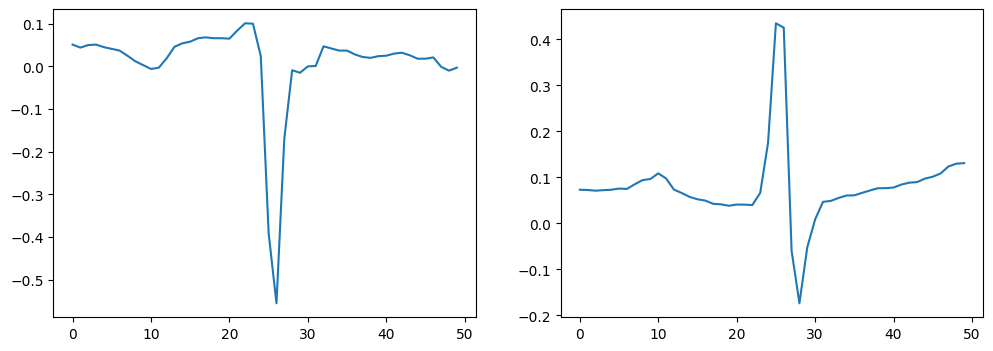

In [87]:
idx = 1
channel = 3
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(label[idx,channel,:50].cpu())

plt.subplot(122)
plt.plot(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:50].cpu())

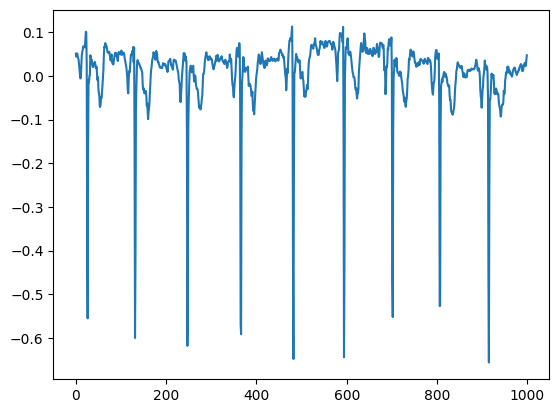

In [77]:
plt.plot(data[idx,channel,:].cpu())

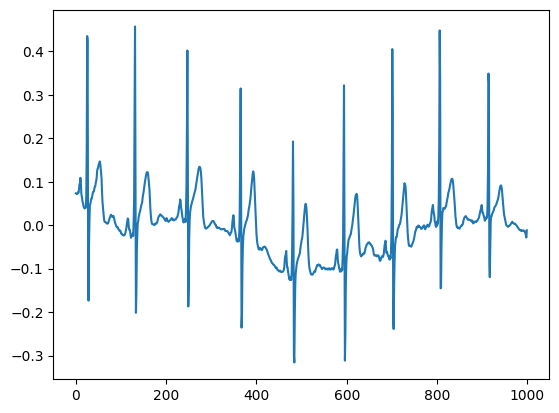

In [78]:
plt.plot(torch.bmm(output2.permute(0, 2, 1), output1)[idx,channel,:].cpu())

In [16]:
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(ECGTransformer, self).__init__()

        self.model_dim = model_dim
        self.pos_encoder = PositionalEncoding(model_dim, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(model_dim, 6)  # 6 is the number of classes
        self.src_mask = None
        self.input_linear = nn.Linear(input_dim, model_dim)  # Adapt input dimension to model dimension
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_linear.bias.data.zero_()
        self.input_linear.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.input_linear(src)  
        src = self.pos_encoder(src)   
        output = self.transformer_encoder(src)  
        output = self.decoder(output.mean(dim=1)) 
        return F.log_softmax(output, dim=-1) 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ECGTransformer(input_dim=1, model_dim=512).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

def acc(op, labels):
    op = torch.softmax(op, dim=1)
    _, preds = torch.max(op, dim=1)
    return (preds == labels).float().mean()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_accuracy = []
    train_loss_sum = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        data = data.unsqueeze(-1)  

        optim.zero_grad()
        output = model(data)
        loss_value = loss_fn(output, label)
        loss_value.backward()
        optim.step()

        train_loss_sum += loss_value.item()
        train_accuracy.append(acc(output, label).item())

    avg_train_accuracy = np.mean(train_accuracy)
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.2f}%')

    model.eval()
    test_accuracy = []
    test_loss_sum = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            data = data.unsqueeze(-1)

            output = model(data)
            loss_value = loss_fn(output, label)

            test_loss_sum += loss_value.item()
            test_accuracy.append(acc(output, label).item())

    avg_test_accuracy = np.mean(test_accuracy)
    avg_test_loss = test_loss_sum / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%')
